In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
df= pd.read_csv("C:\\Users\\Sarrang\\FindDefault\\transformed_data.csv")

In [3]:
len(df)
X = df.iloc[:, :-1].values
y = df.iloc[:, -1].values

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 1)

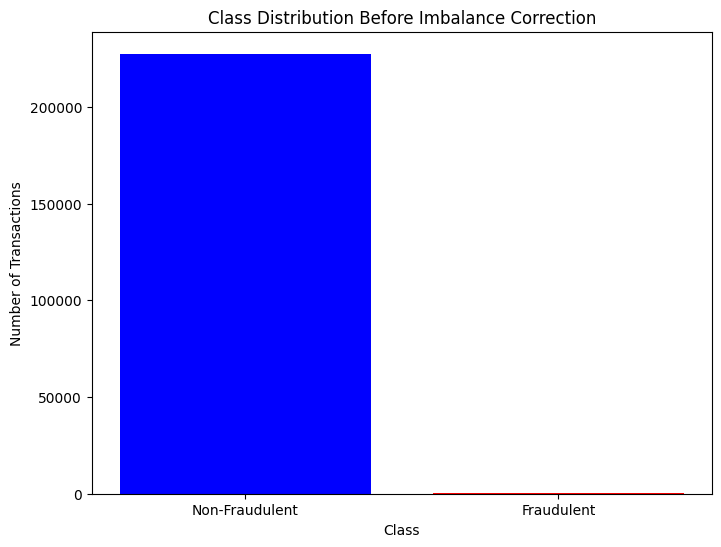

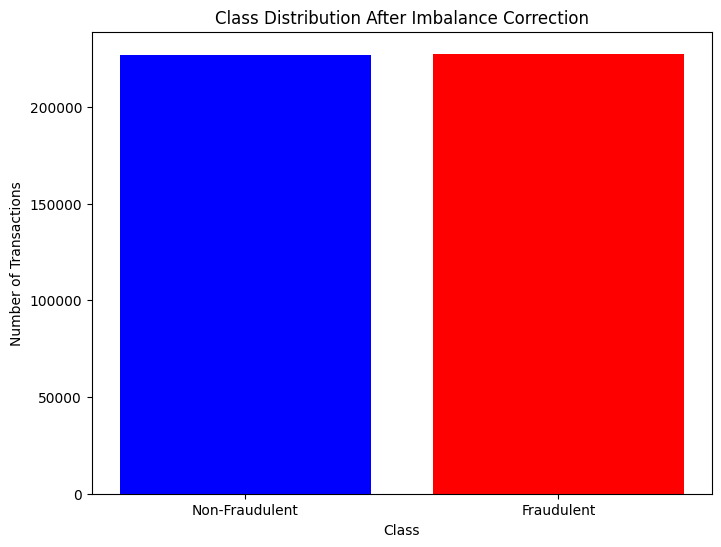

In [6]:
from imblearn.combine import SMOTEENN
smoteenn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smoteenn.fit_resample(X_train, y_train)

unique_classes, class_counts = np.unique(y_train, return_counts=True)
plt.figure(figsize=(8, 6))
plt.bar(unique_classes, class_counts, color=['blue', 'red'])
plt.xticks(unique_classes, ['Non-Fraudulent', 'Fraudulent'])
plt.title('Class Distribution Before Imbalance Correction')
plt.xlabel('Class')
plt.ylabel('Number of Transactions')
plt.show()

# Calculate class distribution after imbalance correction
unique_classes_resampled, class_counts_resampled = np.unique(y_train_resampled, return_counts=True)

# Plot class distribution after imbalance correction
plt.figure(figsize=(8, 6))
plt.bar(unique_classes_resampled, class_counts_resampled, color=['blue', 'red'])
plt.xticks(unique_classes_resampled, ['Non-Fraudulent', 'Fraudulent'])
plt.title('Class Distribution After Imbalance Correction')
plt.xlabel('Class')
plt.ylabel('Number of Transactions')
plt.show()


**Random forest hyperparameter tuning**

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, precision_score

# Define the parameter grid to search
param_dist = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'bootstrap': [True, False]
}

# Define the Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_dist,
                                   scoring='precision', cv=3, verbose=2, n_jobs=-1)

# Fit the model
random_search.fit(X_train_resampled, y_train_resampled)

# Get the best parameters
best_params = random_search.best_params_
print("Best Parameters:", best_params)

# Make predictions
y_pred = random_search.predict(X_test)

# Calculate precision score
precision = precision_score(y_test, y_pred)
print("Precision Score:", precision)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


Best Parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': None, 'bootstrap': False}
Precision Score: 0.7931034482758621
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56875
           1       0.79      0.79      0.79        87

    accuracy                           1.00     56962
   macro avg       0.90      0.90      0.90     56962
weighted avg       1.00      1.00      1.00     56962



In [9]:
classifier=RandomForestClassifier(n_estimators=100,
                                  min_samples_split=2,
                                  min_samples_leaf=4,
                                  max_features='auto',
                                  max_depth=None,
                                  bootstrap=False)

classifier.fit(X_train_resampled,y_train_resampled)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


RandomForestClassifier(bootstrap=False, max_features='auto', min_samples_leaf=4)

In [10]:
y_pred=classifier.predict(X_test)
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56875
           1       0.80      0.79      0.80        87

    accuracy                           1.00     56962
   macro avg       0.90      0.90      0.90     56962
weighted avg       1.00      1.00      1.00     56962



In [11]:
import joblib
joblib.dump(classifier,'rf_smoteENN_FD.joblib')

['rf_smoteENN_FD.joblib']

[[56858    18]
 [   17    69]]


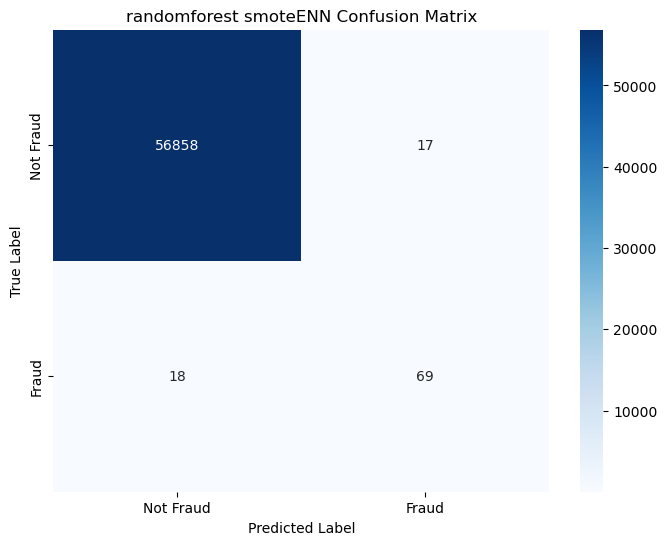

In [5]:
from joblib import load
clf=load("C:\\Users\\Sarrang\\FindDefault\\saved models\\rf_smoteENN_FD.joblib")
y_pred=clf.predict(X_test)
from sklearn.metrics import classification_report,confusion_matrix
print(confusion_matrix(y_pred,y_test))
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d',
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('randomforest smoteENN Confusion Matrix')
plt.show()


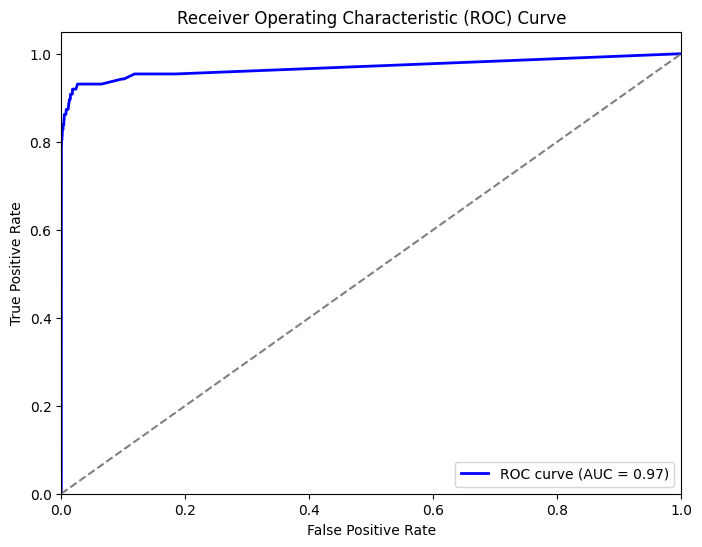

0.9693589996210686


In [13]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_pred_proba = classifier.predict_proba(X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba[:, 1])

auc_roc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = %0.2f)' % auc_roc)
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


print(auc_roc)